In [19]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from skimage.data import coffee

sys.path.append('..')
from libs import gif, inception, utils

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
s = tf.InteractiveSession()
net = inception.get_inception_model()

In [3]:
tf.import_graph_def(net['graph_def'], name='inception')

In [4]:
g = tf.get_default_graph()

In [5]:
names = [op.name for op in g.get_operations()]

In [6]:
names[:30]

['inception/input',
 'inception/conv2d0_w',
 'inception/conv2d0_b',
 'inception/conv2d1_w',
 'inception/conv2d1_b',
 'inception/conv2d2_w',
 'inception/conv2d2_b',
 'inception/mixed3a_1x1_w',
 'inception/mixed3a_1x1_b',
 'inception/mixed3a_3x3_bottleneck_w',
 'inception/mixed3a_3x3_bottleneck_b',
 'inception/mixed3a_3x3_w',
 'inception/mixed3a_3x3_b',
 'inception/mixed3a_5x5_bottleneck_w',
 'inception/mixed3a_5x5_bottleneck_b',
 'inception/mixed3a_5x5_w',
 'inception/mixed3a_5x5_b',
 'inception/mixed3a_pool_reduce_w',
 'inception/mixed3a_pool_reduce_b',
 'inception/mixed3b_1x1_w',
 'inception/mixed3b_1x1_b',
 'inception/mixed3b_3x3_bottleneck_w',
 'inception/mixed3b_3x3_bottleneck_b',
 'inception/mixed3b_3x3_w',
 'inception/mixed3b_3x3_b',
 'inception/mixed3b_5x5_bottleneck_w',
 'inception/mixed3b_5x5_bottleneck_b',
 'inception/mixed3b_5x5_w',
 'inception/mixed3b_5x5_b',
 'inception/mixed3b_pool_reduce_w']

In [7]:
input_name = names[0] + ':0'

In [8]:
x = g.get_tensor_by_name(input_name)

In [9]:
softmax = g.get_tensor_by_name(names[-1] + ':0')

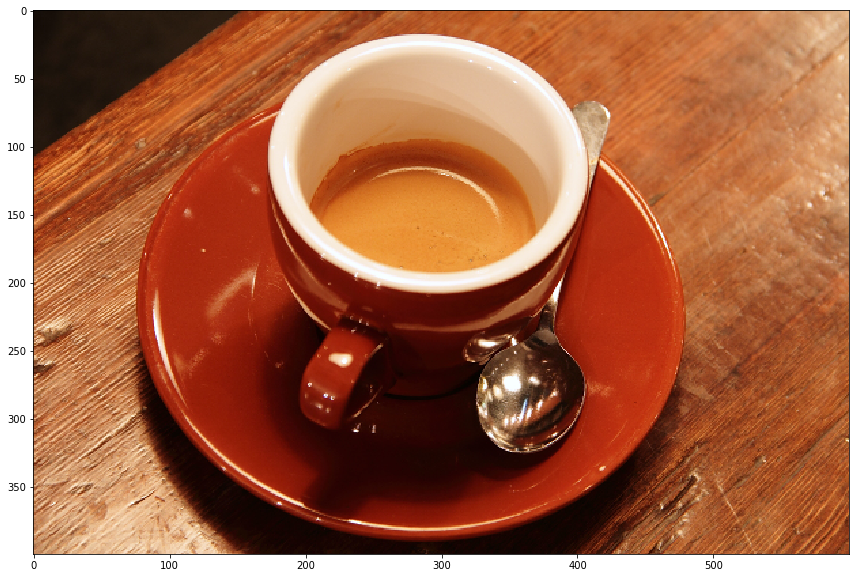

In [10]:
og = coffee()
plt.imshow(og);

In [11]:
og.shape

(400, 600, 3)

In [12]:
img = inception.preprocess(og) # crop, resize, and subtract from mean
print(img.shape)
#plt.imshow(img);

(299, 299, 3)


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
# Reshape to img processing standard tensor ([batch, h, w, c])
img4d = img[np.newaxis]
img4d.shape

(1, 299, 299, 3)

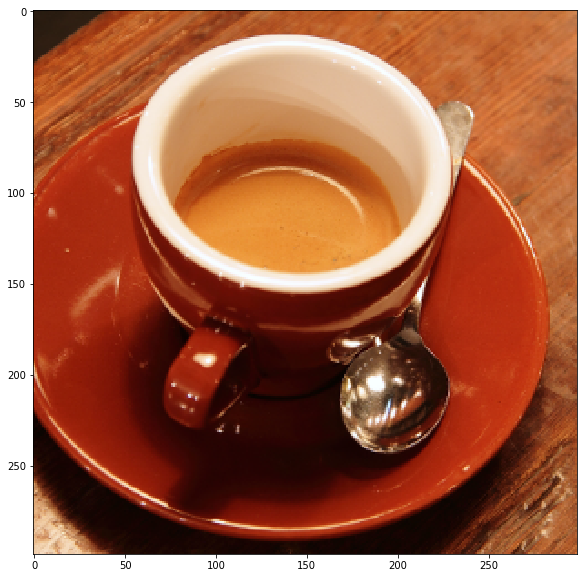

In [14]:
img = img.astype(np.uint8)
plt.imshow(inception.deprocess(img)); # add mean value back in

In [15]:
res = np.squeeze(softmax.eval(feed_dict={x: img4d}))

In [17]:
# Get top predictions
res = np.mean(res, 0)
res = res / np.sum(res)
[(res[idx], net['labels'][idx]) for idx in res.argsort()[-10:][::-1]]

[(0.99849206, (947, 'espresso')),
 (0.000631253, (859, 'cup')),
 (0.00050241494, (953, 'chocolate sauce')),
 (0.00019483209, (844, 'consomme')),
 (0.00013370356, (822, 'soup bowl')),
 (2.2646054e-05, (996, 'coffee mug')),
 (1.0453795e-05, (823, 'eggnog')),
 (2.8054892e-06, (514, 'strainer')),
 (2.4793335e-06, (798, 'red wine')),
 (2.4155261e-06, (892, 'ladle'))]

In [18]:
# Attempt visualization of network filters
W = g.get_tensor_by_name('inception/conv2d0_w:0')
W_eval = W.eval()
W_eval.shape

(7, 7, 3, 64)

In [20]:
W_montage = utils.montage_filters(W_eval)

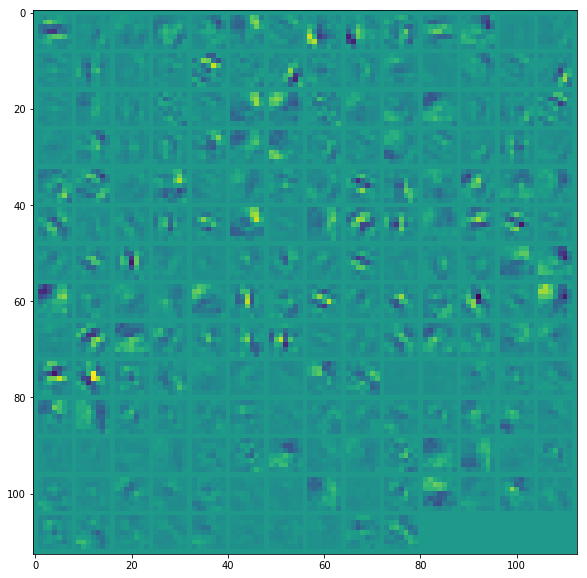

In [23]:
plt.imshow(W_montage, interpolation='nearest');

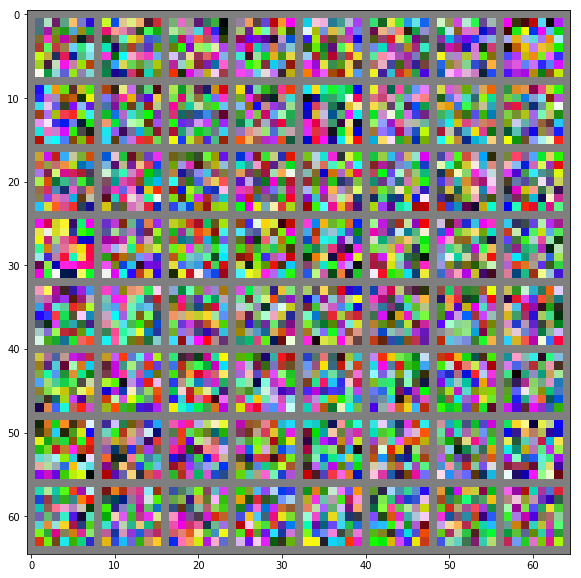

In [29]:
# Parse by color channel
Ws = [utils.montage_filters(W_eval[:, :, [i], :]) for i in range(3)]
Ws = np.rollaxis(np.array(Ws), 0, 3)
plt.imshow(Ws, interpolation='nearest');

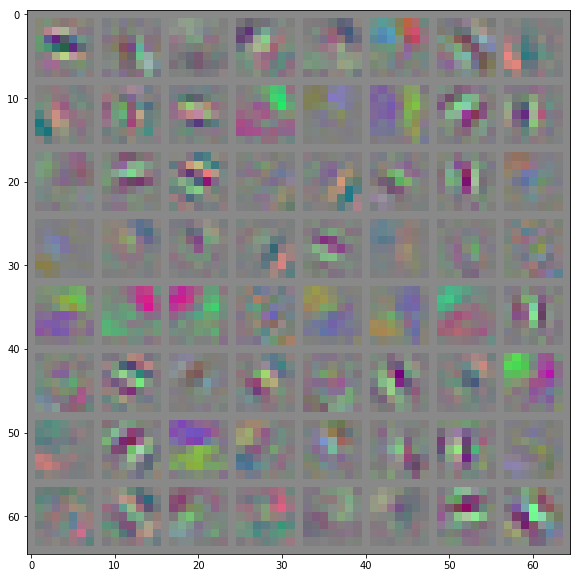

In [30]:
# Normalize ranges
Ws = (Ws / np.max(np.abs(Ws)) * 128 + 128).astype(np.uint8)
plt.imshow(Ws, interpolation='nearest');

In [32]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
layer_shape = tf.shape(feature).eval(feed_dict={x: img4d})
layer_shape # 150x150 bc stride of 2 in convolution; 64 output channels

array([  1, 150, 150,  64], dtype=int32)

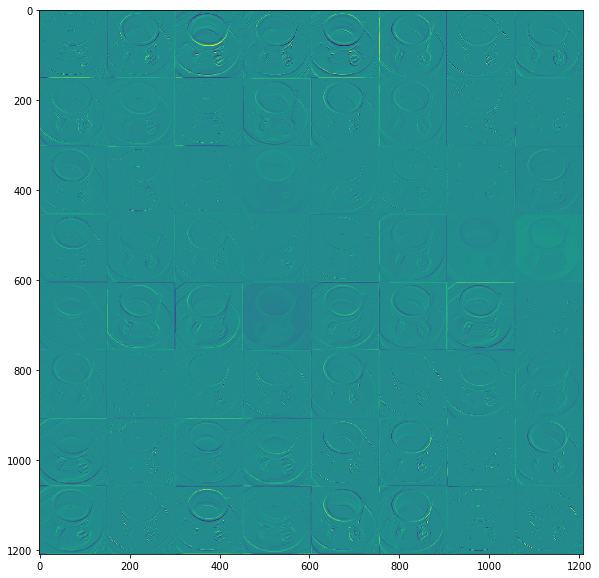

In [35]:
# visualize resulting convolution
f = feature.eval(feed_dict={x: img4d})
montage = utils.montage_filters(np.rollaxis(np.expand_dims(f[0], 3), 3, 2))
plt.imshow(montage);